In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### The goal is to find out how many of these systems have transiting planets.

### Case 1

In [2]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


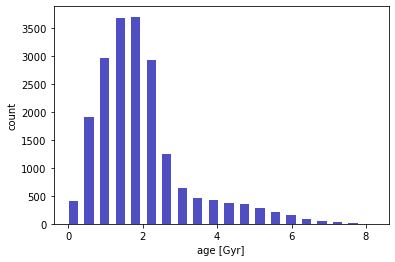

In [38]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Time for kernel density estimator? https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


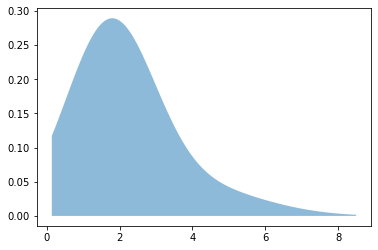

In [7]:
from sklearn.neighbors import KernelDensity

x = berger_kepler.iso_age
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # what else might be better?
kde.fit(x[:, None])

x_d = np.linspace(np.min(x),np.max(x),1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show()

0.08067447284024479
0.13801577758850292
20000 [0.65821822 2.73944945 0.73344344 ... 2.77288288 1.82003003 1.55256256]


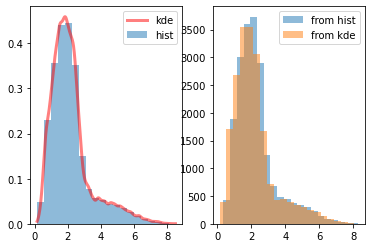

[0.65821822 2.73944945 0.73344344 ... 2.77288288 1.82003003 1.55256256]


In [50]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth=0.2):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1)) # ddof=1 means std divisor is N-1 instead of N
    print(bandwidth/x.std()) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=nbins)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.1) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde
    
stars_age1 = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1)

60000 [  5.20667875  58.08803074 104.39777951 ...   2.57619993 152.74520813
   6.53661139]
[25454  7539  4643  3349  2566  2112  1770  1589  1459  1143  1165  1009
  1005   855   810   799   739   717   654   623]
[  2.0003211   16.89998646  31.79965181  46.69931716  61.59898252
  76.49864787  91.39831322 106.29797858 121.19764393 136.09730928
 150.99697464 165.89663999 180.79630534 195.6959707  210.59563605
 225.4953014  240.39496676 255.29463211 270.19429746 285.09396282
 299.99362817]


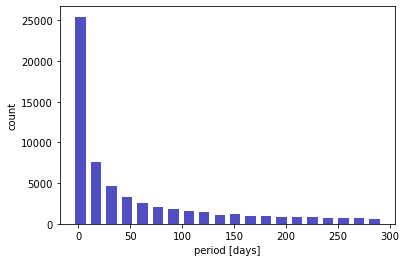

In [41]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[2995 2916 2981 3038 3041 3083 3004 2901 2946 2965 3019 2976 3061 3090
 2900 2972 2974 3008 3052 3078]
[0.69330772 0.9438304  1.19435307 1.44487575 1.69539842 1.9459211
 2.19644377 2.44696645 2.69748913 2.9480118  3.19853448 3.44905715
 3.69957983 3.9501025  4.20062518 4.45114786 4.70167053 4.95219321
 5.20271588 5.45323856 5.70376123]


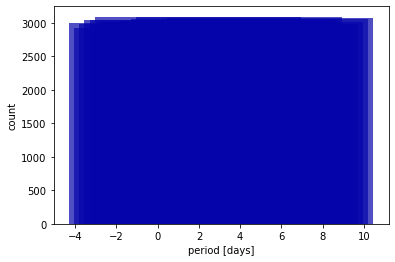

In [51]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

### Case 2

0.23588498675623132
0.1560280665725776
2000 [1.70024024 1.60528529 1.03183183 ... 0.80840841 0.79165165 0.7357958 ]


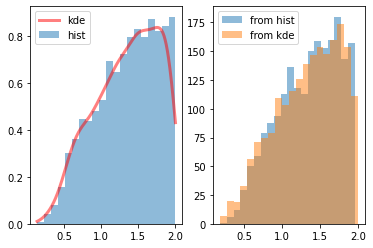

In [53]:
# 2000 systems with five or six planets and age <2 Gyr
# 18000 systems with one or two planets and age >2 Gyr
# should the age distribution be a truncated version of the KDE below and above 2 Gyr?
young = berger_kepler.loc[berger_kepler.iso_age <= 2.].iso_age
old = berger_kepler.loc[berger_kepler.iso_age > 2.].iso_age

stars_age2_young = run_kde(young, 2000)

11000 [42.07981861  2.89885292 10.28544152 ...  7.9768477  73.32686368
  5.21135605]
[4766 1372  825  630  438  370  315  278  250  270  217  202  159  143
  158  135  129  142  102   99]
[  2.0006257   16.89354717  31.78646864  46.67939011  61.57231158
  76.46523305  91.35815453 106.251076   121.14399747 136.03691894
 150.92984041 165.82276188 180.71568336 195.60860483 210.5015263
 225.39444777 240.28736924 255.18029071 270.07321219 284.96613366
 299.85905513]


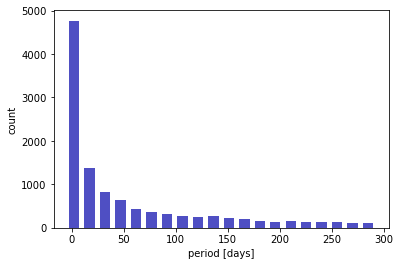

In [46]:
# generate five or six planets for each of the 2000 systems --> 11000 planets
planets_per2_young = loguniform.rvs(2, 300, size=11000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 11000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

0.08316651081001256
0.1613126145450759
18000 [4.11810811 4.69540541 2.76891892 ... 3.65756757 2.1527027  2.05540541]


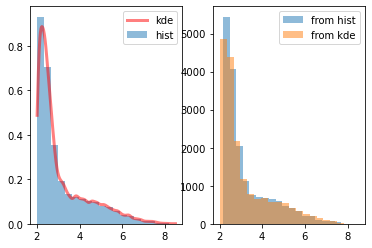

In [54]:
stars_age2_old = run_kde(old, 18000)

27000 [ 7.26885816  6.83660876 28.97404829 ...  6.66290175  6.73247961
 17.24827077]
[11572  3448  1939  1422  1208   930   823   723   647   575   468   446
   447   384   397   369   323   300   310   269]
[  2.00020127  16.89885763  31.79751398  46.69617034  61.5948267
  76.49348306  91.39213942 106.29079578 121.18945214 136.0881085
 150.98676486 165.88542122 180.78407757 195.68273393 210.58139029
 225.48004665 240.37870301 255.27735937 270.17601573 285.07467209
 299.97332845]


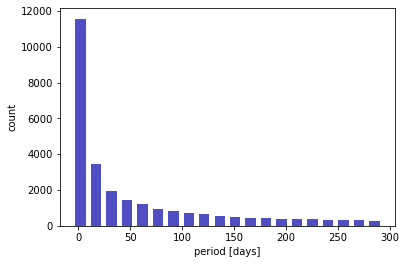

In [47]:
# generate one or two planets for each of the 18000 systems --> 27000 planets
planets_per2_young = loguniform.rvs(2, 300, size=27000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 27000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[ 109  371  575  731 3923 5709 2411 1273  844  869  762  711  556  414
  314  201  128   75   16    8]
[0.1790991  0.59464414 1.01018919 1.42573423 1.84127928 2.25682432
 2.67236937 3.08791441 3.50345946 3.9190045  4.33454955 4.75009459
 5.16563964 5.58118468 5.99672973 6.41227477 6.82781982 7.24336486
 7.65890991 8.07445495 8.49      ]


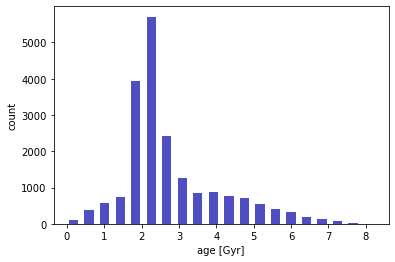

In [62]:
# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars drawn from Berger age distribution
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young)+list(stars_age2_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Why da peak so high?? As we can see below, the 1 Gyr threshold is actually closer to the 10% split than the 2 Gyr threshold. So let's fall back to that.

In [75]:
# check percentage split of 1 Gyr age threshold vs 2 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age <= 1.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 1.]))
print(2514/len(berger_kepler))

print(len(berger_kepler.loc[berger_kepler.iso_age <= 2.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 2.]))
print(10814/len(berger_kepler))

# now check what threshold yields a 10%/90% young/old split
youngest_ten_percent = berger_kepler.iso_age.sort_values().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%
#youngest_ten_percent = stars_age1.sort().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%#
print(len(youngest_ten_percent))
print(youngest_ten_percent.tail())
print(len(stars_age1[:int(len(stars_age1) * 0.1)]))
print(stars_age1[:int(len(stars_age1) * 0.1)])


2514
17455
0.12589513746306777
10814
9155
0.5415393860483749
1996
11450    0.91
2020     0.92
11791    0.92
16754    0.92
919      0.92
Name: iso_age, dtype: float64
2000
[0.14       0.14835836 0.15671672 ... 0.90896897 0.90896897 0.90896897]
